In [ ]:
!pip install geopandas contextily --quiet

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
taxi = pd.read_csv("taxi_data.csv")
zones_lookup = pd.read_csv("taxi_zone_lookup.csv")


In [ ]:
# Airport LocationIDs from lookup (robust to NaNs in Zone)
jfk_mask = zones_lookup["Zone"].fillna("").str.contains("JFK", case=False, na=False)
lga_mask = zones_lookup["Zone"].fillna("").str.contains("LaGuardia", case=False, na=False)

jfk_id = int(zones_lookup.loc[jfk_mask, "LocationID"].iloc[0])
lga_id = int(zones_lookup.loc[lga_mask, "LocationID"].iloc[0])


In [ ]:
# Manhattan pickup zones
manhattan_ids = zones_lookup.loc[zones_lookup["Borough"] == "Manhattan", "LocationID"].tolist()

# Keep only trips that end at JFK or LGA
airport_trips = taxi[taxi["DOLocationID"].isin([jfk_id, lga_id])].copy()

# Keep only trips that start in Manhattan
airport_trips = airport_trips[airport_trips["PULocationID"].isin(manhattan_ids)]

# Count trips by (pickup zone, airport)
airport_counts = (
    airport_trips
      .groupby(["PULocationID", "DOLocationID"])
      .size()
      .reset_index(name="trips")
)

# Pivot to separate columns for JFK and LGA
airport_counts_pivot = (
    airport_counts
      .pivot(index="PULocationID", columns="DOLocationID", values="trips")
      .fillna(0)
      .rename(columns={jfk_id: "to_JFK", lga_id: "to_LGA"})
      .reset_index()
)

# Total trips to either airport
airport_counts_pivot["to_airports_total"] = (
    airport_counts_pivot["to_JFK"] + airport_counts_pivot["to_LGA"]
)

airport_counts_pivot.head()

DOLocationID,PULocationID,to_JFK,to_LGA,to_airports_total
0,4.0,6.0,2.0,8.0
1,12.0,1.0,0.0,1.0
2,13.0,103.0,135.0,238.0
3,24.0,24.0,39.0,63.0
4,41.0,24.0,23.0,47.0


In [ ]:
# Official TLC taxi zone polygons (same LocationID system)
# TLC now serves this via a CloudFront URL instead of the older S3 path.
taxi_zones_url = "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip"

taxi_zones_gdf = gpd.read_file(taxi_zones_url)

# Keep only Manhattan polygons
manhattan_shapes = taxi_zones_gdf[taxi_zones_gdf["borough"] == "Manhattan"].copy()

manhattan_shapes[["LocationID", "zone", "borough"]].head()

,LocationID,zone,borough
3,4,Alphabet City,Manhattan
11,12,Battery Park,Manhattan
12,13,Battery Park City,Manhattan
23,24,Bloomingdale,Manhattan
40,41,Central Harlem,Manhattan


In [ ]:
# Join airport trip counts onto Manhattan polygons
manhattan_heat = manhattan_shapes.merge(
    airport_counts_pivot,
    how="left",
    left_on="LocationID",
    right_on="PULocationID"
)

# Replace NaNs for zones with zero airport trips
for col in ["to_JFK", "to_LGA", "to_airports_total"]:
    manhattan_heat[col] = manhattan_heat[col].fillna(0)

# Optional: log-transform counts so Midtown doesn't dominate the color scale
manhattan_heat["log_airport_trips"] = np.log1p(manhattan_heat["to_airports_total"])

manhattan_heat[["LocationID", "zone", "to_JFK", "to_LGA", "to_airports_total", "log_airport_trips"]].head()

,LocationID,zone,to_JFK,to_LGA,to_airports_total,log_airport_trips
0,4,Alphabet City,6.0,2.0,8.0,2.197225
1,12,Battery Park,1.0,0.0,1.0,0.693147
2,13,Battery Park City,103.0,135.0,238.0,5.476464
3,24,Bloomingdale,24.0,39.0,63.0,4.158883
4,41,Central Harlem,24.0,23.0,47.0,3.871201


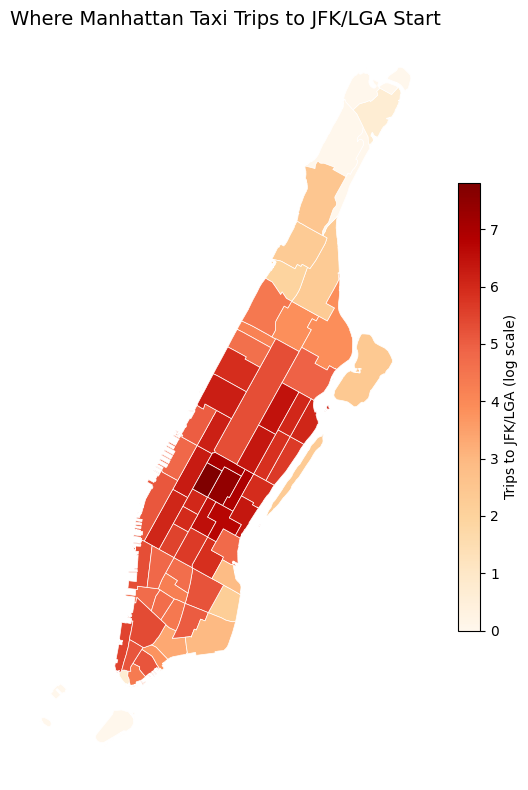

In [ ]:
fig, ax = plt.subplots(figsize=(6, 8))

manhattan_heat.plot(
    column="log_airport_trips",      # or "to_airports_total" if you prefer raw counts
    cmap="OrRd",
    linewidth=0.5,
    edgecolor="white",
    ax=ax,
    legend=True,
    legend_kwds={
        "label": "Trips to JFK/LGA (log scale)",
        "shrink": 0.6
    }
)

ax.set_axis_off()
ax.set_title("Where Manhattan Taxi Trips to JFK/LGA Start", fontsize=14)
plt.tight_layout()

# Save a high-res image for your slides
plt.savefig("manhattan_airport_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()